If you haven't gone through [Carl's Tutorial](https://github.com/carlshan/intro_to_machine_learning/blob/master/lessons/Reinforcement_Learning/RL_Tutorial.md), you may want to go through that and implement the hill-climbing policy before attempting this tutorial. I would not recommend implementing the policy gradient strategy unless you're interested in learning more about lower-level tensorflow. This tutorial uses the keras, like the others this semester.

Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

# Installation
To be able to run the animation below, make sure you have the latest version of matplotlib, by running `pip3 install matplotlib --upgrade`

In [27]:
%matplotlib inline
import json
import numpy as np
import random
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Flatten
from keras.layers import Conv2D
from keras.optimizers import sgd
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

## Define the game environment and replay classes

In [80]:
class Catch(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_basket_center = 1
        self.max_basket_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves basket according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, basket_center = self.state
        # move the basket unless this would move it off the edge of the grid
        new_basket_center = min(max(self.min_basket_center, basket_center + movement), self.max_basket_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_basket_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and basket and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, basket_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, basket_center-1:basket_center + 2] = 1  # draw 3-pixel basket
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was caught, -1 if it was dropped, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, basket_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - basket_center) <= 1:
                return 1 # it caught the fruit
            else:
                return -1 # it dropped the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if game is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        game_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, game_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            basket center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        basket_center = random.randint(self.min_basket_center, self.max_basket_center)
        self.state = np.asarray([fruit_x, fruit_y, basket_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            game_over: boolean
        Add the states and game over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1:] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim[0], env_dim[1], env_dim[2]))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            game_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i:i+1] = starting_observation
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if game_over: 
                # if the game is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the game is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




## Creating Snake Enviorment

In [67]:
class Snake(object):
    def __init__(self, grid_size = 45, max_moves_multiplyer = 1):
        self.max_moves = (grid_size**2) *  max_moves_multiplyer
        self.grid_size = grid_size
        snake = [[int(grid_size/2), int(grid_size/2)]]
        snake.append([snake[0][0] - 1, snake[0][1]])
        fruit_x = np.random.randint(0, grid_size)
        fruit_y = np.random.randint(0, grid_size)
#         fruit_x = snake[0][0] + 1
#         fruit_y = snake[0][1]
        move = 0
        self.state = [[fruit_x, fruit_y], snake, [move]]
    
    def _update_state(self, action):
        [fruit_x, fruit_y], snake, [move] = self.state
        
        direction = [snake[0][0] - snake[1][0], snake[0][1] - snake[1][1]]
        if action == 0:
            movement = direction # Forward
        elif action == 1:
            movement = [-1*direction[1], direction[0]] # Right
        elif action == 2:
            movement = [direction[1], -1*direction[0]] # Down
        else:
            raise Exception('Invalid action {}'.format(action))
        
        snake_new = [np.add(snake[0], movement).tolist()] + snake
        
        if [fruit_x, fruit_y] not in snake_new:
            snake_new = snake_new[:-1]
        
        #print("Snake: {}".format(snake))
        self.state = [[fruit_x, fruit_y], snake_new, [move + 1]]
        
    def _draw_state(self):
        
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        [fruit_x, fruit_y], snake, [move] = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        for coord in snake:
            try:
                canvas[coord[1]][coord[0]] = 1  # draw snake
            except IndexError:
                canvas = np.zeros(im_size)
                #print('dead')
                break
        return canvas
        
    def _get_reward(self):
        
        [fruit_x, fruit_y], snake, [move] = self.state
        if snake[0] in snake[1:]:
            #print("ouch")
            return -1 # it hit itself
        if snake[0][0] < 0 or snake[0][0] > self.grid_size - 1 or snake[0][1] < 0 or snake[0][1] > self.grid_size - 1:
            return -1 # it hit a wall
        if [fruit_x, fruit_y] in snake:
            #print("got fruit?")
            while [fruit_x, fruit_y] in snake: # reseting fruit probably, need a better way if the snake gets good.
                fruit_x = np.random.randint(0, grid_size)
                fruit_y = np.random.randint(0, grid_size)
            self.state[0] = [fruit_x, fruit_y]
            self.state[2] = [0]
            return 1 # it ate the fruit
        if move > (self.max_moves) + (len(snake)):
            return -1 # ran out of time
#         if (fruit_x - snake[0][0])**2 + (fruit_y - snake[0][1])**2 < (fruit_x - snake[1][0])**2 + (fruit_y - snake[1][1])**2:
#             return 1
        else:
            return 0 # the fruit is still on the board
    
    def observe(self):
        
        canvas = self._draw_state()
        
        return np.array([np.expand_dims(canvas, axis = 2)])
    
    def act(self, action):
        
        self._update_state(action)
        reward = self._get_reward()
        if reward != -1:
            observation = self.observe()
        else:
            [fruit_x, fruit_y], snake, [move] = self.state
            self.state = [[fruit_x, fruit_y], snake[1:], [move]] # removing head bc if it goes out of bounds then the observe does not work.
            observation = self.observe()
        
        game_over = (reward < 0) # if the reward is -1 then the snake died
        return observation, reward, game_over
    
    def reset(self):
        
        snake = [[int(grid_size/2), int(grid_size/2)]]
        snake.append([snake[0][0] - 1, snake[0][1]])
        fruit_x = np.random.randint(0, grid_size)
        fruit_y = np.random.randint(0, grid_size)
#         fruit_x = snake[0][0] + 1
#         fruit_y = snake[0][1]
        move = 0
        self.state = [[fruit_x, fruit_y], snake, [move]]

##  Functions for creating, training, and visualizing the model

In [98]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, move_forward, move_right]
max_memory = 500
hidden_size = 32
batch_size = 50
grid_size = 10
discount = .99

def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Conv2D(filters = hidden_size, kernel_size = 5, input_shape = (grid_size, grid_size, 1), activation='relu'))
    model.add(Conv2D(filters = hidden_size, kernel_size = 3, activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.2, clipnorm = 1.0), "mse")

    # Define environment/game
    env = Snake(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory, discount = discount)
    
    return model, env, exp_replay


def train_model(model, env, exp_replay, num_episodes):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    totals = []
    for episode in range(num_episodes):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        starting_observation = env.observe()
        
        catch_count = 0

        while not game_over:
            # get next action
            if np.random.rand() <= epsilon:
                # epsilon of the time, we just choose randomly
                action = np.random.randint(0, num_actions, size=1)
            else:
                # find which action the model currently thinks is best from this state
                q = model.predict(starting_observation)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            new_observation, reward, game_over = env.act(action)
            if reward == 1:
                catch_count += 1

            # store experience
            exp_replay.remember([starting_observation, action, reward, new_observation], game_over)

            # get data updated based on the stored experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

            # train model on the updated data
            loss += model.train_on_batch(inputs, targets)

            starting_observation = new_observation # for next time through the loop
        
        totals.append(catch_count)
        totals = totals[max(len(totals)-10, 0):]
        avg = round(sum(totals)/len(totals), 2)

        # Print update from this episode
        print("Episode {:04d}/{:04d} | Loss {:.4f} | Catch count {} | Average {}".format(episode, num_episodes-1, loss, catch_count, avg))


def create_animation(model, env, num_games):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_games: integer, the number of games to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the games and collect all of the images for each observed state
    
    observations = []
    for _ in range(num_games):
        print("game start")
        env.reset()
        observation = env.observe()
        observations.append(observation)
        game_over = False
        while game_over == False:
            q = model.predict(observation)
            action = np.argmax(q[0])
#             action = np.random.randint(0,4)
#             action = 1
            # apply action, get rewards and new state
            observation, reward, game_over = env.act(action)
            observations.append(observation)
            #print("move")
            print(reward)
        print("game end")
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Let's create our model and game environment and see how it does before training

In [99]:
model, env, exp_replay = build_model()

game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end
game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end
game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end


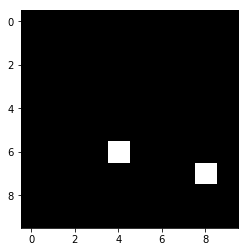

In [82]:
animation = create_animation(model, env, num_games=3)
IPython.display.HTML(animation.to_jshtml())

## Now train the model and see how much better it is at catching the fruit

Episode 0000/0999 | Loss 0.0237 | Catch count 0 | Average 0.0
Episode 0001/0999 | Loss 0.2213 | Catch count 0 | Average 0.0
Episode 0002/0999 | Loss 0.3407 | Catch count 0 | Average 0.0
Episode 0003/0999 | Loss 0.3335 | Catch count 0 | Average 0.0
Episode 0004/0999 | Loss 0.3275 | Catch count 0 | Average 0.0
Episode 0005/0999 | Loss 0.2914 | Catch count 0 | Average 0.0
Episode 0006/0999 | Loss 0.2518 | Catch count 1 | Average 0.14
Episode 0007/0999 | Loss 0.3303 | Catch count 0 | Average 0.12
Episode 0008/0999 | Loss 0.4352 | Catch count 0 | Average 0.11
Episode 0009/0999 | Loss 0.0283 | Catch count 1 | Average 0.2
Episode 0010/0999 | Loss 0.2022 | Catch count 1 | Average 0.3
Episode 0011/0999 | Loss 0.0501 | Catch count 0 | Average 0.3
Episode 0012/0999 | Loss 0.1742 | Catch count 0 | Average 0.3
Episode 0013/0999 | Loss 0.1968 | Catch count 0 | Average 0.3
Episode 0014/0999 | Loss 0.8997 | Catch count 1 | Average 0.4
Episode 0015/0999 | Loss 0.7568 | Catch count 0 | Average 0.4
Episo

Episode 0133/0999 | Loss 0.3753 | Catch count 0 | Average 0.1
Episode 0134/0999 | Loss 0.5925 | Catch count 0 | Average 0.1
Episode 0135/0999 | Loss 0.0156 | Catch count 0 | Average 0.1
Episode 0136/0999 | Loss 0.0894 | Catch count 0 | Average 0.1
Episode 0137/0999 | Loss 0.0708 | Catch count 1 | Average 0.2
Episode 0138/0999 | Loss 0.2969 | Catch count 0 | Average 0.1
Episode 0139/0999 | Loss 0.0386 | Catch count 0 | Average 0.1
Episode 0140/0999 | Loss 0.5329 | Catch count 0 | Average 0.1
Episode 0141/0999 | Loss 0.6014 | Catch count 0 | Average 0.1
Episode 0142/0999 | Loss 0.1827 | Catch count 0 | Average 0.1
Episode 0143/0999 | Loss 0.2492 | Catch count 2 | Average 0.3
Episode 0144/0999 | Loss 1.2320 | Catch count 0 | Average 0.3
Episode 0145/0999 | Loss 1.2569 | Catch count 0 | Average 0.3
Episode 0146/0999 | Loss 1.1583 | Catch count 0 | Average 0.3
Episode 0147/0999 | Loss 0.8465 | Catch count 0 | Average 0.2
Episode 0148/0999 | Loss 1.1344 | Catch count 0 | Average 0.2
Episode 

Episode 0265/0999 | Loss 2698.7560 | Catch count 0 | Average 0.2
Episode 0266/0999 | Loss 3432.9029 | Catch count 0 | Average 0.2
Episode 0267/0999 | Loss 2125.1129 | Catch count 0 | Average 0.2
Episode 0268/0999 | Loss 652.2816 | Catch count 1 | Average 0.2
Episode 0269/0999 | Loss 309.2870 | Catch count 0 | Average 0.2
Episode 0270/0999 | Loss 1073.8177 | Catch count 1 | Average 0.2
Episode 0271/0999 | Loss 2300.9761 | Catch count 1 | Average 0.3
Episode 0272/0999 | Loss 3842.5518 | Catch count 1 | Average 0.4
Episode 0273/0999 | Loss 331.4155 | Catch count 0 | Average 0.4
Episode 0274/0999 | Loss 343.1770 | Catch count 0 | Average 0.4
Episode 0275/0999 | Loss 216.5557 | Catch count 0 | Average 0.4
Episode 0276/0999 | Loss 312.2629 | Catch count 0 | Average 0.4
Episode 0277/0999 | Loss 287.8862 | Catch count 0 | Average 0.4
Episode 0278/0999 | Loss 1041.3998 | Catch count 0 | Average 0.3
Episode 0279/0999 | Loss 195.0425 | Catch count 0 | Average 0.3
Episode 0280/0999 | Loss 842.8397

Episode 0392/0999 | Loss 1394.0709 | Catch count 1 | Average 0.2
Episode 0393/0999 | Loss 2850.1342 | Catch count 0 | Average 0.2
Episode 0394/0999 | Loss 3935.2035 | Catch count 0 | Average 0.2
Episode 0395/0999 | Loss 6678.2881 | Catch count 1 | Average 0.3
Episode 0396/0999 | Loss 3535.0731 | Catch count 0 | Average 0.3
Episode 0397/0999 | Loss 1672.1704 | Catch count 0 | Average 0.3
Episode 0398/0999 | Loss 6296.5099 | Catch count 0 | Average 0.3
Episode 0399/0999 | Loss 5641.5472 | Catch count 0 | Average 0.2
Episode 0400/0999 | Loss 591.8253 | Catch count 0 | Average 0.2
Episode 0401/0999 | Loss 2694.5370 | Catch count 2 | Average 0.4
Episode 0402/0999 | Loss 7653.8802 | Catch count 0 | Average 0.3
Episode 0403/0999 | Loss 5377.0148 | Catch count 0 | Average 0.3
Episode 0404/0999 | Loss 11637.2673 | Catch count 0 | Average 0.3
Episode 0405/0999 | Loss 5430.8015 | Catch count 0 | Average 0.2
Episode 0406/0999 | Loss 701.7102 | Catch count 0 | Average 0.2
Episode 0407/0999 | Loss 1

Episode 0517/0999 | Loss 24756.7405 | Catch count 0 | Average 0.3
Episode 0518/0999 | Loss 37663.4609 | Catch count 0 | Average 0.3
Episode 0519/0999 | Loss 42349.1535 | Catch count 0 | Average 0.3
Episode 0520/0999 | Loss 17792.1657 | Catch count 1 | Average 0.4
Episode 0521/0999 | Loss 14742.0173 | Catch count 0 | Average 0.3
Episode 0522/0999 | Loss 11492.7922 | Catch count 0 | Average 0.2
Episode 0523/0999 | Loss 23834.2567 | Catch count 0 | Average 0.2
Episode 0524/0999 | Loss 24345.6517 | Catch count 0 | Average 0.2
Episode 0525/0999 | Loss 11924.9609 | Catch count 0 | Average 0.2
Episode 0526/0999 | Loss 6839.3489 | Catch count 0 | Average 0.1
Episode 0527/0999 | Loss 4530.2895 | Catch count 1 | Average 0.2
Episode 0528/0999 | Loss 20586.0747 | Catch count 0 | Average 0.2
Episode 0529/0999 | Loss 10098.1408 | Catch count 0 | Average 0.2
Episode 0530/0999 | Loss 21897.7128 | Catch count 0 | Average 0.1
Episode 0531/0999 | Loss 2075.5238 | Catch count 0 | Average 0.1
Episode 0532/

Episode 0643/0999 | Loss 29567.5750 | Catch count 0 | Average 0.2
Episode 0644/0999 | Loss 11959.0455 | Catch count 1 | Average 0.3
Episode 0645/0999 | Loss 25700.9546 | Catch count 1 | Average 0.4
Episode 0646/0999 | Loss 13780.2267 | Catch count 0 | Average 0.4
Episode 0647/0999 | Loss 7171.0207 | Catch count 0 | Average 0.3
Episode 0648/0999 | Loss 2781.6150 | Catch count 0 | Average 0.3
Episode 0649/0999 | Loss 85204.5132 | Catch count 1 | Average 0.3
Episode 0650/0999 | Loss 39478.4296 | Catch count 0 | Average 0.3
Episode 0651/0999 | Loss 39465.2799 | Catch count 0 | Average 0.3
Episode 0652/0999 | Loss 5328.0409 | Catch count 0 | Average 0.3
Episode 0653/0999 | Loss 10265.8008 | Catch count 0 | Average 0.3
Episode 0654/0999 | Loss 23664.1995 | Catch count 0 | Average 0.2
Episode 0655/0999 | Loss 4593.9819 | Catch count 0 | Average 0.1
Episode 0656/0999 | Loss 25376.2687 | Catch count 1 | Average 0.2
Episode 0657/0999 | Loss 12818.6277 | Catch count 0 | Average 0.2
Episode 0658/0

Episode 0768/0999 | Loss 709.8692 | Catch count 0 | Average 0.2
Episode 0769/0999 | Loss 4848.9474 | Catch count 1 | Average 0.3
Episode 0770/0999 | Loss 9182.9026 | Catch count 0 | Average 0.3
Episode 0771/0999 | Loss 5464.4796 | Catch count 0 | Average 0.3
Episode 0772/0999 | Loss 12778.0127 | Catch count 0 | Average 0.3
Episode 0773/0999 | Loss 14650.9649 | Catch count 1 | Average 0.4
Episode 0774/0999 | Loss 1303.1280 | Catch count 0 | Average 0.2
Episode 0775/0999 | Loss 20838.2459 | Catch count 2 | Average 0.4
Episode 0776/0999 | Loss 13696.9280 | Catch count 1 | Average 0.5
Episode 0777/0999 | Loss 19776.0473 | Catch count 0 | Average 0.5
Episode 0778/0999 | Loss 47316.0513 | Catch count 0 | Average 0.5
Episode 0779/0999 | Loss 2119.9544 | Catch count 0 | Average 0.4
Episode 0780/0999 | Loss 10226.8638 | Catch count 0 | Average 0.4
Episode 0781/0999 | Loss 5764.6805 | Catch count 0 | Average 0.4
Episode 0782/0999 | Loss 2555.0597 | Catch count 0 | Average 0.4
Episode 0783/0999 |

Episode 0893/0999 | Loss 70792.1193 | Catch count 0 | Average 0.1
Episode 0894/0999 | Loss 45000.2693 | Catch count 0 | Average 0.1
Episode 0895/0999 | Loss 56763.3408 | Catch count 0 | Average 0.1
Episode 0896/0999 | Loss 24838.0095 | Catch count 0 | Average 0.1
Episode 0897/0999 | Loss 32109.9608 | Catch count 0 | Average 0.1
Episode 0898/0999 | Loss 6239.6727 | Catch count 1 | Average 0.2
Episode 0899/0999 | Loss 122705.4152 | Catch count 0 | Average 0.1
Episode 0900/0999 | Loss 24217.2554 | Catch count 0 | Average 0.1
Episode 0901/0999 | Loss 47165.3509 | Catch count 0 | Average 0.1
Episode 0902/0999 | Loss 5490.0394 | Catch count 0 | Average 0.1
Episode 0903/0999 | Loss 45110.0012 | Catch count 0 | Average 0.1
Episode 0904/0999 | Loss 6924.8636 | Catch count 0 | Average 0.1
Episode 0905/0999 | Loss 19282.5051 | Catch count 2 | Average 0.3
Episode 0906/0999 | Loss 76428.3696 | Catch count 0 | Average 0.3
Episode 0907/0999 | Loss 75567.7011 | Catch count 2 | Average 0.5
Episode 0908

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end
game start
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
game end


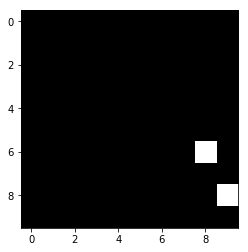

In [100]:
train_model(model, env, exp_replay, num_episodes=1000)
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

# Possible Exercises:
1. Add a validation function, to make it easier to assess models.
1. We've been looking at convolutional neural networks for image processing. Try changing the model to use convolutional layers. Does this seem to work any better?
1. Change the code so that the basket is trying to avoid getting hit by the fruit.
1. Change the code so the game keeps going until the basket misses the fruit. (To test that this is working, you may want to change the number of games in the animation to 1.) How should this change the rewards that the model gets?
1. Change the game to something entirely different.
1. Try changing how the training works, using more of a policy gradient strategy.

In [94]:
a = [1,2,3]
a[-2:]

[2, 3]

In [50]:
np.expand_dims([[1,2],[3,4]], axis = 2)

array([[[1],
        [2]],

       [[3],
        [4]]])